# Example usage of NRSur3dq8BMSRemnant fit.

In [12]:
# Silence an annoying lal warning
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import surfinBH

In [2]:
fit_name = 'NRSur3dq8BMSRemnant'

## Load the fit, this only needs to be done once at the start of a script

In [3]:
fit = surfinBH.LoadFits(fit_name)

Loaded NRSur3dq8BMSRemnant fit.


## Read the documentation

In [4]:
help(fit)

Help on Fit3dq8BMS in module surfinBH._fit_evaluators.fit_3dq8BMS object:

class Fit3dq8BMS(surfinBH.surfinBH.SurFinBH)
 |  Fit3dq8BMS(name)
 |
 |  A class for the NRSur3dq8BMSRemnant model presented in Da Re et al.,
 |  arxiv:????.?????. This model is referred to as surfinBH3dq8BMS in the paper.
 |
 |  This model predicts the supertransation modes up to ell = 8 and the
 |  3 components of the boost velocity of the BMS transformation from the
 |  inspiral (PN) BMS frame to the remnant black hole BMS frame. The boost
 |  velocity coincides with the remnant black hole kick velocity as observed
 |  from the inspiral (PN) BMS frame.
 |
 |  The model was trained on nonprecessing binary black hole systems. The fits
 |  are done using Gaussian Process Regression (GPR) and also provide an error
 |  estimate along with the fit value.
 |
 |  This model has been trained in the parameter space:
 |      q <= 8, |chiAz| <= 0.8, |chiBz| <= 0.8
 |
 |  ==================================================

## Evaluate the fits

In [ ]:
q = 4.3             # Mass ratio q>=1
chiA = [0,0,0.6]    # Spin of larger BH (z-direction only)
chiB = [0,0,-0.7]   # Spin of smaller BH (z-direction only)

## Evaluate the fits and GPR error estimate.

#this model fits the supertranslation parameter alpha and the boost 
#velocity v associated to the BMS transformation from the PN BMS frame to
#the remnant BMS frame

# Outputs:
# - supertranslation parameter alpha and 1-sigma error estimate alpha_err
#   NOTE: alpha is a complex array. Each component is a spherical harmonic mode of alpha
#     the order of the modes in the array is (0,0),(1,-1),(1,0),(1,1),(2,-2),(2,-1),(2,0),(2,1),(2,2),...
#     (same order used in spherical_functions and scri package)
# - boost velocity boost and 1-sigma error estimate boost_err

alpha, boost, alpha_err, boost_err = fit.all(q, chiA, chiB)

# to get a specific supertranslation mode from alpha you can also use the spherical_function package function LM_index
def LM_index(ell,m):
    """ Returns the index in the alpha array corresponding to the ell,m mode
    """
    return ell * (ell + 1) + m


# access a specific ell,m mode of alpha
ell,m = 2,0
alpha[LM_index(ell,m)]
# cartesian components of boost velocity
boost[0] # x-component
boost[1] # y-component
boost[2] # z-component

## Waveform mapping (requires sxs and scri packages)

In [6]:
import sxs
import scri
from scri.asymptotic_bondi_data.map_to_superrest_frame import MT_to_WM, WM_to_MT
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Loading the PN (inspiral) and superrest (remnant black hole frame) waveforms. 
# Both waveforms are rotated after the frame fix so that they have the black holes 
# aligned with the x axis with the hevier one
# on the positive x-axis as explained in arxiv:?????????
try:
    # When running the notebook interactively
    h_PN_al = MT_to_WM(WM_to_MT(sxs.load('rhOverM_SXS:BBH:1450_BondiCce_R0260_PN_aligned.h5')), dataType = scri.h)
    h_superrest_al = MT_to_WM(WM_to_MT(sxs.load('rhOverM_SXS:BBH:1450_BondiCce_R0260_superrest_aligned.h5')), dataType = scri.h)
    metadata = sxs.metadata.Metadata.from_file('metadata_SXS:BBH:1450.json')
except:
    # When pytest uses nbconvert to run the notebook, from one directory up
    h_PN_al = MT_to_WM(WM_to_MT(sxs.rpdmb.load('examples/rhOverM_SXS:BBH:1450_BondiCce_R0260_PN_aligned.h5')), dataType = scri.h)
    h_superrest_al = MT_to_WM(WM_to_MT(sxs.rpdmb.load('examples/rhOverM_SXS:BBH:1450_BondiCce_R0260_superrest_aligned.h5')), dataType = scri.h)
    metadata = sxs.metadata.Metadata.from_file('examples/metadata_SXS:BBH:1450.json')

In [15]:
# loading the mass ratio and spins associated to these waveforms
mA = metadata["reference-mass1"]
mB = metadata["reference-mass2"]
q = max(mA,mB)/min(mA,mB)
chiA = metadata["reference-dimensionless-spin1"]
chiB = metadata["reference-dimensionless-spin2"]
chiA = [0,0,chiA[2]]    # Spin of larger BH (z-direction only)
chiB = [0,0,chiB[2]]   # Spin of smaller BH (z-direction only)

# evaluation of the BMS transformation from the surrogate
alpha, boost, alpha_err, boost_err = fit.all(q, chiA, chiB)

# map the PN waveform with the surrogate transformation
h_sur = h_PN_al.transform(supertranslation = alpha,
            frame_rotation = np.array([1.,0.,0.,0.]),
            boost_velocity = boost
            )

# set the peak time of the news to zero to align the waveform mapped with the surrogate
t_peak = h_sur.t[np.argmax(MT_to_WM(WM_to_MT(h_sur).dot, dataType = scri.hdot).norm())]
h_sur.t = h_sur.t - t_peak

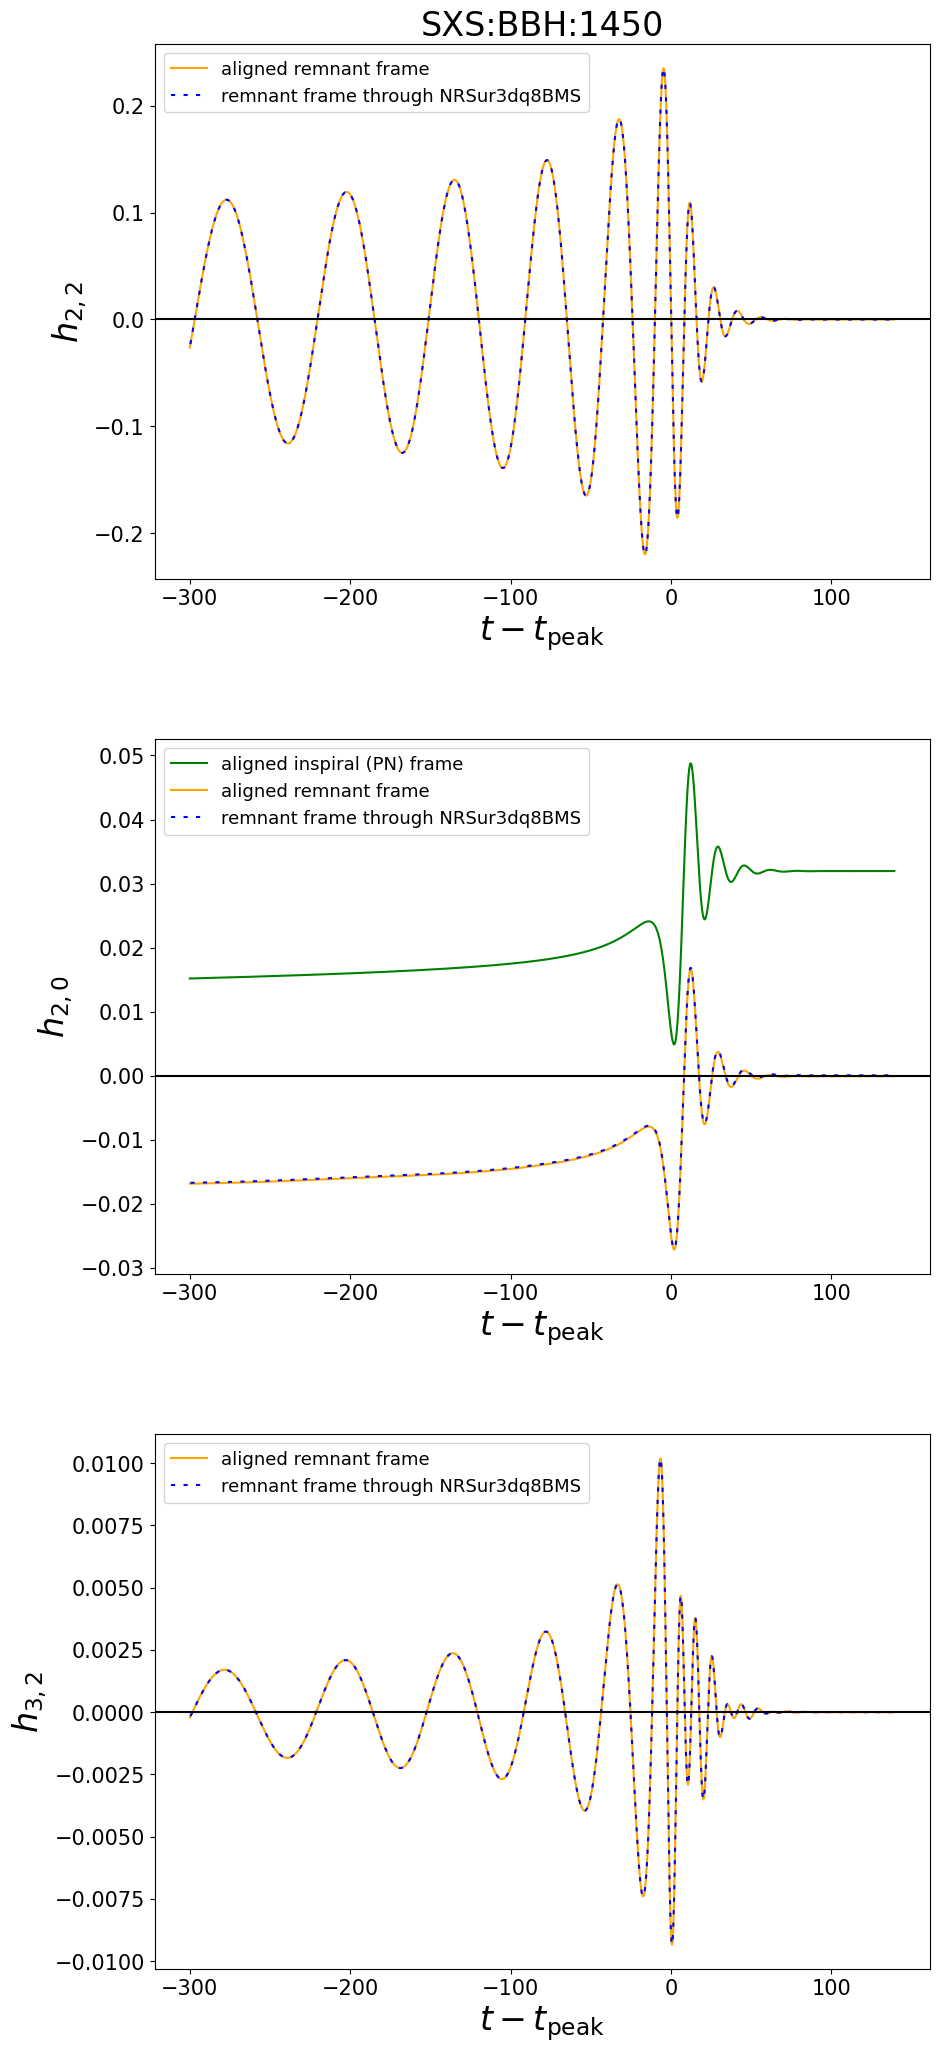

In [19]:
modes = [(2,2),(2,0),(3,2)]
fig, ax = plt.subplots(nrows=len(modes), ncols=1,
                       figsize=(10,25))
plt.subplots_adjust(hspace = 0.3, wspace = 0)

for i, mode in enumerate(modes):
    ell, m = mode
    if i == 1:
        ax[i].plot(h_PN_al.t, h_PN_al.data[:,h_PN_al.index(ell,m)].real, label = 'aligned inspiral (PN) frame', color = 'green')
    ax[i].plot(h_superrest_al.t, h_superrest_al.data[:,h_superrest_al.index(ell,m)].real, label = 'aligned remnant frame', color = 'orange')
    ax[i].plot(h_sur.t, h_sur.data[:,h_sur.index(ell,m)].real, '--', dashes = [2,4], label = 'remnant frame through NRSur3dq8BMS', color = 'blue')
    ax[i].set_ylabel(r'$h_{' + f'{ell},{m}' + r'}$', fontsize = 24)
    ax[i].set_xlabel(r'$t - t_{\mathrm{peak}}$', fontsize = 24)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    if i == 0:
        ax[i].set_title('SXS:BBH:1450', fontsize = 24)
    ax[i].axhline(0, color = 'black')
    ax[i].legend(fontsize = 13)
plt.show()


## Total displacement memory from supertranslation parameter

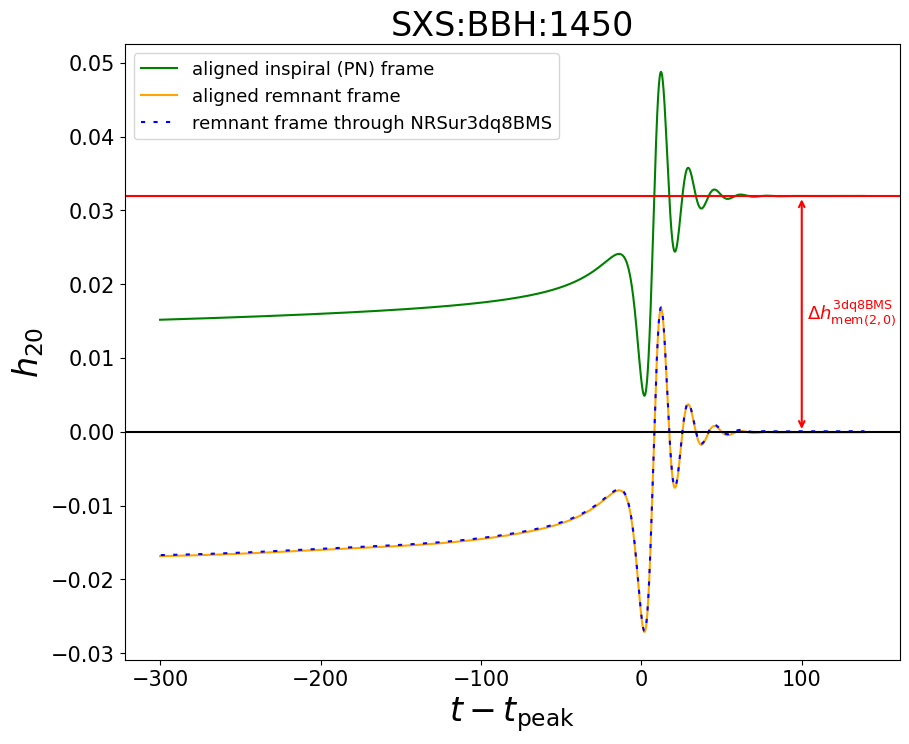

In [18]:
def eth_squared(alpha):
    """ Returns the spherical harmonic modes of eth^2 operator applied to a spin 0 scalar
        on the two sphere
    """
    res = np.zeros(np.size(alpha) ,dtype = 'complex')
    for ell in range(int(np.sqrt(np.size(alpha)) - 1)):
        for m in range(-ell, ell + 1):
            if ell == 0 or ell == 1:
                res[LM_index(ell,m)] = 0
            else:
                eth_squared_op = np.sqrt(ell * (ell + 1) * (ell - 1) * (ell  + 2) / 4)
                res[LM_index(ell,m)] = 2* eth_squared_op * alpha[LM_index(ell,m)]
    return res



# computation of total displacement memory contribuition to the strain as eth^2(alpha), from 
# the alpha calculated by NRSur3dq8BMS
Delta_h_mem = eth_squared(alpha)


# plot of displacement memory in the 20 mode

fig, ax = plt.subplots(figsize = (10,8))
ax.plot(h_PN_al.t, h_PN_al.data[:,h_PN_al.index(2,0)].real, label = 'aligned inspiral (PN) frame', color = 'green')
ax.plot(h_superrest_al.t, h_superrest_al.data[:,h_superrest_al.index(2,0)].real, label = 'aligned remnant frame', color = 'orange')
ax.plot(h_sur.t, h_sur.data[:,h_sur.index(2,0)].real, '--', dashes = [2,4], label = 'remnant frame through NRSur3dq8BMS', color = 'blue')
ax.axhline(Delta_h_mem[LM_index(2,0)].real , color = 'red')
ax.axhline(0, color = 'black')

# Plot displacement memory computed with NRSur3dq8BMS
ax.annotate('', xy=(100, 0), xytext=(100, Delta_h_mem[LM_index(2,0)].real),
            arrowprops=dict(arrowstyle="<->", lw=1.5, color = 'red'))
ax.text(131, 0.5 * Delta_h_mem[LM_index(2,0)].real, r'$\Delta h^{\mathrm{3dq8BMS}}_{\mathrm{mem(2,0)}}$' , fontsize=13, ha='center', va='center', color = 'red')

ax.set_ylabel(r'$h_{20}$', fontsize = 24)
ax.set_xlabel(r'$t - t_{\mathrm{peak}}$', fontsize = 24)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize = 13)
ax.set_title('SXS:BBH:1450', fontsize = 24)
plt.show()